you need to build the cmake and then the makefile in order to import the chess library!

In [1]:
import sys, pathlib
root = pathlib.Path.cwd().parents[0]
build = root / "build"
for p in (str(build), str(root)):
    if p not in sys.path: sys.path.insert(0, p)

import chess_py
import chess as pychess

print("C++ module at:", chess_py.__file__)
print("python-chess at:", pychess.__file__)

# Ensure we don't have duplicate loads of the C++ module
mods = [m for m in sys.modules if m == "chess_py" or m.endswith(".chess_py") or "chess_py" in m]
print("Modules containing 'chess_py':", mods)


C++ module at: /home/giovanni/Desktop/chess_RL/build/chess_py.cpython-312-x86_64-linux-gnu.so
python-chess at: /home/giovanni/Desktop/chess_RL/.venv/lib/python3.12/site-packages/chess/__init__.py
Modules containing 'chess_py': ['chess_py']


In [2]:
# import matplotlib.pyplot as plt

# import sys
# sys.path.insert(0, "../")
# from build import chess_py as chess
# from utils.plot_chess import plot_game
# # from utils.opponent_move import TwoPlyEnv, LichessDefender

# all'inizio del notebook (prima di qualunque import)
import sys, pathlib
root = pathlib.Path.cwd().parents[0]  # project root se notebook sta in doc/
build = root / "build"
utils = root / "utils"
for p in (str(build), str(root), str(utils)):
    if p not in sys.path: sys.path.insert(0, p)

import chess_py
from utils.opponent_move import TwoPlyEnv, LichessDefender  # wrapper
from utils.plot_chess import plot_game                      # usa python-chess
import matplotlib.pyplot as plt


## `Game` and `Move` classes

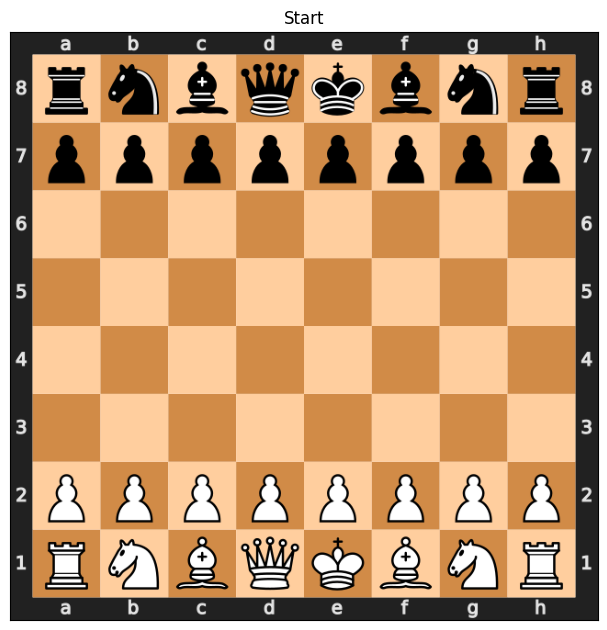

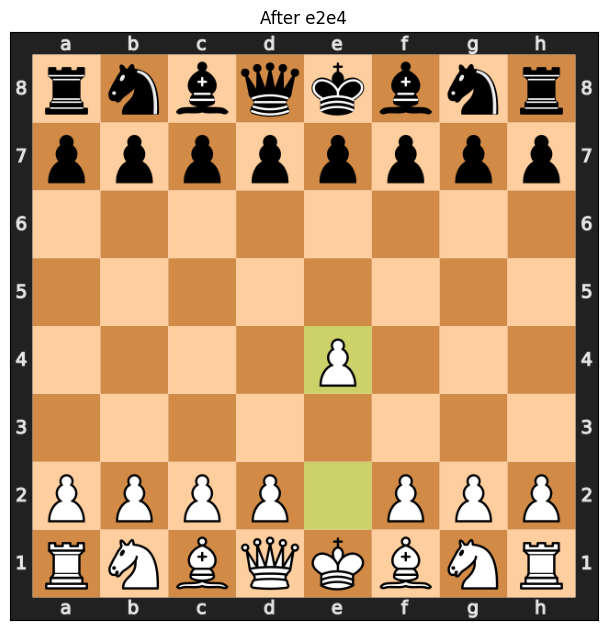

In [3]:
g = chess_py.Game()
g.reset_from_fen("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")
plot_game(
    g, 
    title="Start",
    coordinates=True
    )
plt.show()

# Make a move and re-plot
m = g.parse_move("e2","e4")  # or chess.Move.from_strings(g, "e2","e4") if you added that helper
g.do_move(m)
plot_game(
    g,
    # save_path="output/plots/turn_0.png",
    title="After e2e4",
    flipped=False,
    coordinates=True,
    lastmove="e2e4",    # opzionale: evidenzia l'ultima mossa
    # arrows=["g1f3"],    # opzionale: frecce
    # squares=["e4","d5"] # opzionale: evidenzia case
)
plt.show()

two ways to parse a move

In [ ]:
g = chess_py.Game()
m1 = chess_py.Move.from_strings(g, "g1", "f3")

g.do_move(m1)
print(g.to_fen())

m2 = chess_py.Move.from_uci(g, "b8c6")
g.do_move(m2)
print(g.to_fen())

## `Env` class

The `Env` class represents the RL's environment. It contains the state, emits the reward, is able to evolve.

In [ ]:
# Create a new game
game = chess_py.Game()

# Create Env (gamma=1.0, step_penalty=0.0 for default behavior)
env = chess_py.Env(game, gamma=0.99, step_penalty=0.01)

# Display initial state
print(env)  # uses __str__ from Env

`env.state()` returns the state info (see `/include/environment.hpp`)

In [ ]:
env.state()

to make the env evolve (in the RL sense) we use the `.step(Move)` function. The move argument is the action that the agent makes and the environment evolves according to the chess rules (if the passed move is valid). The `.step` functions returns the pair: reward, a bool that indicates if it is the terminal state or not (i.e. checkmate)

In [ ]:
env = chess_py.Env(game, gamma=0.99, step_penalty=0.01)
mv = chess_py.Move.from_strings(env.state(), "e2", "e4")  # env.state() returns Game
step = env.step(mv)
print(env)


In [ ]:
plot_game(env.state(), title="After e2e4")
plt.show()

In [ ]:

print(step.reward, step.done)

Nice website to build position and return FEN: https://www.redhotpawn.com/chess/chess-fen-viewer.php

In [ ]:
# env constructor from fen

env = chess_py.Env("8/8/8/8/8/2k5/8/1K6 w - - 0 1", gamma=0.99, step_penalty=0.01)
plot_game(env.state())
plt.show()

In [ ]:
# write demo of count pieces

env.is_terminal()

In [9]:
# Make the C++ env with step_penalty=0 (we handle rewards here)
g = chess_py.Game()
env_cpp = chess_py.Env(g, 1.0, 0.0)
env_cpp.reset_from_fen("8/8/8/8/8/8/k7/KQR5 w - - 0 1")

env = TwoPlyEnv(env_cpp, defender=LichessDefender())   # or SyzygyDefender("/path/to/tb")

# Training loop (tabular Q-learning)
fen = env_cpp.to_fen()
white_uci = "c2c8q"  # example
sr = env.step(white_uci)
# sr.reward is a composed reward; sr.done tells you if the episode ended


NameError: name 'chess_py' is not defined

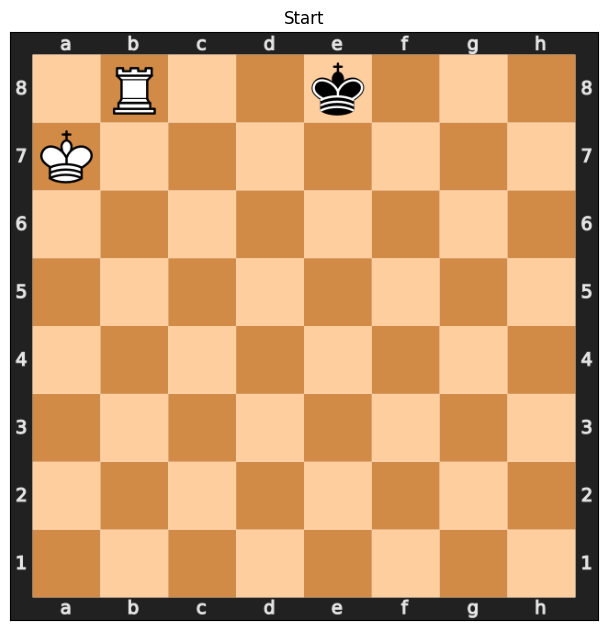

[<Move>, <Move>, <Move>]


In [4]:
g = chess.Game()
g.reset_from_fen("1R2k3/K7/8/8/8/8/8/8 b - - 0 1")
plot_game(g, title="Start")
plt.show()

print(g.legal_moves(chess.BLACK))

In [6]:
env_cpp = chess_py.Env("1R2k3/K7/8/8/8/8/8/8 b - - 0 1", 1.0, 0.0)

env = TwoPlyEnv(env_cpp, defender=LichessDefender())   # or SyzygyDefender("/path/to/tb")

# white_uci = "c2c8"  # example
# sr = env.step(white_uci)
# sr.reward # is a composed reward; 
# sr.done #tells you if the episode ended